In [ ]:
!pip install langchain langgraph cassio

In [7]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:NOfXjlOpnnYtdCMQjgLPxTBS:4aa2cc0555a7cbfd550dcfccd5da526278c485914192b040c48ba222c801cb1b" # enter the "AstraCS:..." string found in in your Token JSON file"
ASTRA_DB_ID="043a432f-f173-4b5d-9383-edc12a571431"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [ ]:
!pip install langchain_community

In [ ]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [10]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://www.airtel.in/",
]


# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)



[Document(metadata={'source': 'https://www.airtel.in/', 'title': 'Airtel: Prepaid, Postpaid, Broadband, DTH, Bank & Business', 'description': "We are India's leading telecom provider offering Prepaid, Postpaid, Broadband, DTH, Payment Banks & Business solutions. Join us today with special benefits!", 'language': 'en'}, page_content='Airtel: Prepaid, Postpaid, Broadband, DTH, Bank & BusinessYou need to enable JavaScript to run this app.')]

In [12]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

In [14]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 1 headlines.


In [15]:
retriever=astra_vector_store.as_retriever()

In [16]:
retriever.invoke("What is airtel",ConsistencyLevel="LOCAL_ONE")

[Document(id='a016ac970f26446491ef276b4d7e7e49', metadata={'description': 'Contact us Airtel @0124-4222 222. To Know airtel latest release, read all (PR) press release and News announces online.', 'language': 'No language found.', 'source': 'https://www.airtel.in/press-release/', 'title': 'Contact Us | Airtel : Latest Press Release & News'}, page_content='Airtel\n                Business announces  changes to its leadership team\nBharti Airtel (“Airtel”), one of India’s leading\n              telecommunications services providers, today announced changes to it...\n\n\nMatter\n                Motor Works partners with  Airtel Business for its AERA\n                  motorbikes\n\nMatter Motor Works, a technology-led innovation start-up, and Bharti\n              Airtel, one\n              of India’s leading telecommunications...\n\n\nAirtel\n                powers 5G access to the  Kochi water metro route\nBharti Airtel (“Airtel”), one of India’s leading\n              telecommunication

### Router

In [20]:

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "workflow_sim_swap","recharge_plan_workflow","conversation"] = Field(
        ...,
        description="Route to vectorstore, workflows, or fallback conversation.",
    )

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=userdata.get('groq_api_key')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)


# Prompt
system = """You are an expert at handling Airtel-related queries and are responsible for directing them to the appropriate resource.
Route queries about Airtel’s general services, network issues, or company-related information to the vectorstore,
SIM swap-related queries to the SIM swap workflow, recharge or plan details to the recharge plan workflow,
and if the query doesn't fit these categories or is ambiguous, rely on a fallback conversation model using the LLM for further assistance.
Ensure accuracy in routing to provide the best possible user experience."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router

In [22]:

print(
    question_router.invoke(
        {"question": "tell me myy avaliable recharge plan?"}
    )
)

datasource='recharge_plan_workflow'


In [ ]:
!pip install langchain_community

## Graph

In [24]:


from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [25]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [26]:
def sim_swap_workflow(state):
    """Trigger SIM swap workflow in a step-by-step manner."""
    # Check the current state of the workflow and prompt accordingly
    print("---sim workflow--- ")
    question = state["question"]

    print(question)
    # Check if the workflow has been initiated, ask for the next step
    name = input("Please provide your full name for the SIM swap?")
    phone_number = input("Please provide your phone number for SIM swap")

    return {"sim_swap_details": name+" "+phone_number, "question": question}


In [27]:
### Edges ###


def route_question(state):
    """
    Route question to "vectorstore", "workflow_sim_swap","recharge_plan_workflow","conversation"

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source.datasource == "workflow_sim_swap":
        print("---ROUTE QUESTION TO SIM SWAP---")
        return "workflow_sim_swap"
    elif source.datasource == "recharge_plan_workflow":
        print("---ROUTE QUESTION TO RECHARGE PLAN---")
        return "recharge_plan_workflow"
    elif source.datasource == "conversation":
        print("---ROUTE QUESTION TO CONVERSATION---")
        return "conversation"

In [28]:
import requests

def recharge_plan_workflow(state):
    """Trigger Recharge Plan Workflow."""
    question = state["question"]

    # Check if the workflow has been initiated, ask for the phone number
    if state.get("step") == "ask_phone_number":
        # User has already initiated the workflow, now ask for phone number
        return {"generation": "Please provide your phone number for the recharge plans.", "step": "collect_phone_number"}

    elif state.get("step") == "collect_phone_number":
        # Now that we have the phone number, let's fetch the plans
        phone_number = question
        url = f"https://www.airtel.in/recharge/prepaid/?siNumber={phone_number}&icid=recharge_rail"

        # Simulate an API call to get the available plans (you can replace this with actual scraping if necessary)
        response = requests.get(url)
        if response.status_code == 200:
            available_plans = response.text  # Or parse the response if it's JSON/HTML
            return {"generation": f"Here are the available plans for {phone_number}: {available_plans}", "step": "completed"}
        else:
            return {"generation": "Sorry, there was an issue retrieving the plans. Please try again.", "step": "completed"}

    # Initial check for recharge plan intent and start workflow
    elif "recharge plan" in question.lower() and not state.get("step"):
        # Start by asking for the phone number
        return {"generation": "Please provide your phone number to retrieve available recharge plans.", "step": "ask_phone_number"}

    return state


In [30]:
from langgraph.graph import END, StateGraph, START

# Workflow
workflow = StateGraph(GraphState)

# Add nodes for different workflows
workflow.add_node("vectorstore", retrieve)
workflow.add_node("workflow_sim_swap", sim_swap_workflow)
workflow.add_node("recharge_plan_workflow", recharge_plan_workflow)
workflow.add_node("conversation", sim_swap_workflow)  # You can replace this with a general fallback conversation handler if needed.

# Conditional routing based on the question intent
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "vectorstore",
        "workflow_sim_swap": "workflow_sim_swap",
        "recharge_plan_workflow": "recharge_plan_workflow",
        "conversation": "conversation",
    }
)
# End nodes
workflow.add_edge("vectorstore", END)
workflow.add_edge("workflow_sim_swap", END)
workflow.add_edge("recharge_plan_workflow", END)
workflow.add_edge("conversation", END)
app = workflow.compile()

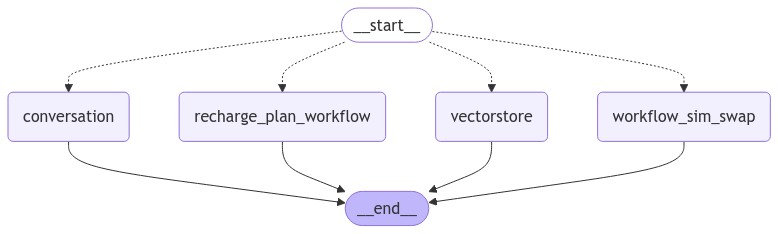

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import requests
from pprint import pprint

def run_chatbot():
    # Initialize the workflow state
    state = {
        "question": "",
        "step": None
    }

    # Continuously interact with the user until the conversation is completed
    while True:
        # Get user input (the question to be processed)
        state["question"] = input("You: ")

        # Exit the loop if the user types "quit"
        if state["question"].lower() in ["quit", "exit", "stop"]:
            print("Bot: Goodbye!")
            break

        # Process the input using the workflow graph
        outputs = app.stream(state)

        # Display the generated response for each node in the workflow
        for output in outputs:
            for key, value in output.items():
                print(f"Bot: {value}")
                # print(f"Bot: {value['generation']}")

                # Check if the workflow is completed
                if value.get("step") == "completed":
                    print("Bot: Thank you! The workflow is now complete.")
                    break

        print("\n---\n")

# Assuming the rest of your workflow and graph are already compiled into 'app'
run_chatbot()


You: how to change the sim?
---ROUTE QUESTION---
---ROUTE QUESTION TO SIM SWAP---
Bot: {'question': 'how to change the sim?'}

---

You: sim swap intent is fine ,but we are not able to access what we want?
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


Bot: {'question': 'sim swap intent is fine ,but we are not able to access what we want?', 'documents': [Document(id='18ea4fb632884d68ba31dae74097472f', metadata={'description': 'Contact airtel customer care number anytime at 121. Help us to support you better, dial 121 from airtel network.', 'language': 'No language found.', 'source': 'https://www.airtel.in/contact-us', 'title': 'Airtel Customer Care Number - Contact Us @121'}, page_content='Telecom Tariff\nRights\n                Issue\nQIP &\n                FCCB Issue\nTerms &\n                Conditions\nAirtel Blogs\n\n\n\nHelp at Hand\n\n\nFind a store\nCheck Coverage\nOwnership Transfer\n\nManage Your\n                account\nISP Near Me\nWynk Music\nWi-Fi FAQs\nDTH FAQs\nAirtel Xstream FAQs\n\nPostpaid FAQs\nStores near me\nDTH Consumer Corner\n\n\n\nNew Connections\n\nBuy DTH New Connection\nBuy Prepaid New Connection\nBuy Postpaid New Connection\nBuy Broadband New Connection\nBuy Airtel Black\n                Plan\nBuy Xstre

In [34]:
from pprint import pprint

while:

# Run
inputs = {
    "question": "airtel sim swap"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO SIM SWAP---
"Node 'workflow_sim_swap':"
'\n---\n'


KeyError: 'documents'